In [1]:
import matplotlib.pyplot as plt
from aerobot.io import RESULTS_PATH, load_results_dict, DATA_PATH
from aerobot.plot import plot_configure_mpl, PRETTY_NAMES
from aerobot.contigs import KMER_FEATURE_TYPES
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
import os
from typing import List
import glob 

%load_ext autoreload 
%autoreload 2 

plot_configure_mpl(n_colors=6) # Want at least one color for each genome have results for. 

/home/prichter/miniconda3/envs/aerobot/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONTIGS_PATH = os.path.join(DATA_PATH, 'contigs')

# These are the feature types which I currently have results for. 
feature_types = ['nt_1mer', 'nt_2mer', 'nt_3mer', 'aa_1mer', 'aa_2mer', 'aa_3mer']

# SI Figure 6

This figure shows the results of applying the trained classifier to normalized contig data.

How would be best to show this... Probably want to plot one genome at a time, or perhaps multiple genomes on the same plot? And then fit a regression line through the data points. I expect the trend will be the same across correctly-predicted genomes. As a side note, it is probably best to select for genomes where the end prediction of the model was correct. 

In [3]:
# Get the IDs of the genomes which have been analyzed. 
# These can be extracted from the names of the files in the RESULTS_PATH directory. 
genome_ids = []
for path in glob.glob(os.path.join(RESULTS_PATH, 'predict_contigs*')):
    filename = os.path.basename(path)
    filename = filename.replace('predict_contigs_', '')
    filename = '_'.join(filename.split('_')[:2])
    genome_ids.append(filename)

genome_ids = set(genome_ids)

In [4]:
# Load the correct labels for each genome. 
genome_labels = pd.read_csv(os.path.join(CONTIGS_PATH, 'genomes.csv'), index_col=0).set_index('genome_id').to_dict(orient='dict')
genome_labels = genome_labels['label']

# Organize the contigs results into DataFrames for plotting. 
contigs_results = dict() 
for feature_type in feature_types:
    # contigs_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, ''))
    contigs_results[feature_type] = dict() # I think it would be good to have another layer of dictionaries for genome IDs. 
    for genome_id in genome_ids:
        predictions_df = pd.read_csv(os.path.join(RESULTS_PATH, f'predict_contigs_{genome_id}_{feature_type}.csv'))
        predictions_df['correct'] = predictions_df.prediction.values == genome_labels[genome_id] # Create a new column indicating if the prediction matches the label. 
        
        y_vals = predictions_df[['contig_size', 'correct']].groupby('contig_size').mean().values.ravel()
        x_vals = np.unique(predictions_df.contig_size.values)

        # Is the whole genome prediction correct?
        if y_vals[-1] == 1: # The last value in the y-value array indicates if model prediction on the entire genome is correct. 
            y_vals, x_vals = y_vals[:-1], x_vals[:-1] # The length of the complete genome is much larger than any of the contigs, so plots look better if it's removed.  
            contigs_results[feature_type][genome_id] = (x_vals, y_vals)
        else:
            pass
            # print(f'Genome {genome_id} is excluded for feature type {feature_type}, as model prediction on the complete genome is incorrect.')
    print(len(contigs_results[feature_type]), f'genomes used for feature type {feature_type}.')

4 genomes used for feature type nt_1mer.
4 genomes used for feature type nt_2mer.
6 genomes used for feature type nt_3mer.
3 genomes used for feature type aa_1mer.
5 genomes used for feature type aa_2mer.
6 genomes used for feature type aa_3mer.


In [5]:
# How best to visualize this? Multiple genomes on the same plot / with the same color, and feature types on different sub-panels?
# Or all feature types on one plot?

# Judging by the fact that the results for different genomes look fairly different, I think it's better to split up the plots by feature type. 

In [17]:
def plot_figure_6(contigs_results:pd.DataFrame, fig:plt.Figure=None, grids:List[GridSpec]=None):
    
    for i, feature_type in enumerate(feature_types):
        ax = fig.add_subplot(grids[i])
        ax.set_title(PRETTY_NAMES[feature_type], loc='left')

        # Extract the results for the specified feature type. 
        genome_results = contigs_results[feature_type]
        labels, handles = [],[]
        for genome_id, results in genome_results.items():
            labels.append(genome_id)
            ax.scatter(*results, s=2)
            
            linreg = linregress(*results) # Fit a line to the data. 
            x_vals = np.linspace(0, max(results[0]))
            y_vals = linreg.slope * x_vals + linreg.intercept

            handles += ax.plot(x_vals, y_vals, lw=1)
        
        ax.legend(handles=handles, labels=labels)
    


/home/prichter/miniconda3/envs/aerobot/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == "__main__":


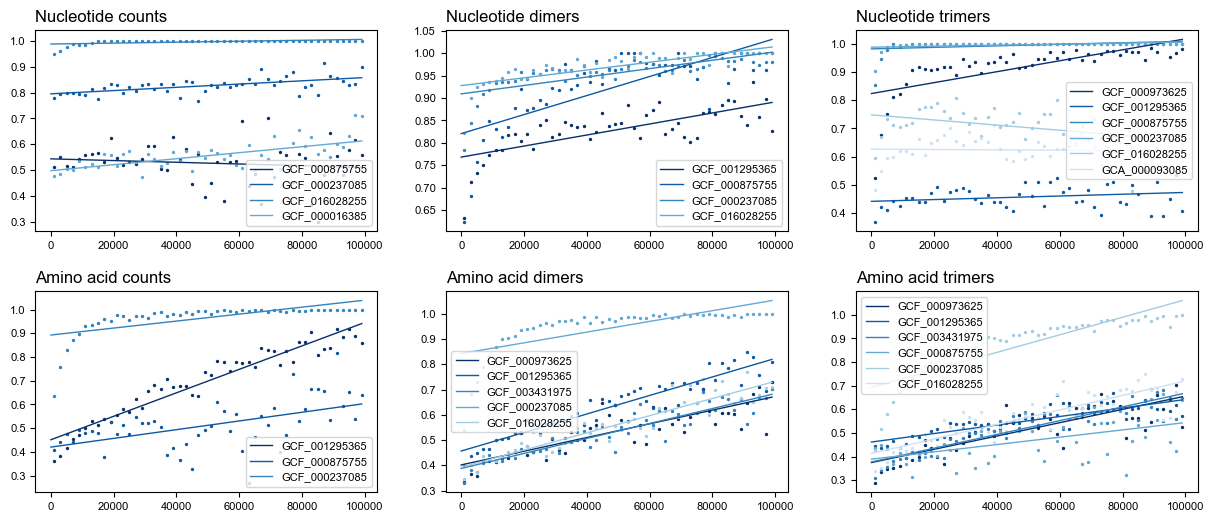

In [18]:
n_rows, n_cols = 2, 3
fig = plt.figure(figsize=(5 * n_cols, 3 * n_rows))

grids = GridSpec(n_rows, n_cols, hspace=0.3)
grids = [grids[0, i] for i in range(n_cols)] + [grids[1, i] for i in range(n_cols)]

plot_figure_6(contigs_results, fig=fig, grids=grids)

plt.tight_layout()